In [3]:
import math
import torch
import torch.nn as nn
import torch.utils
import torch.utils.data
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
EPS = torch.finfo(torch.float).eps # Numerical logs

In [5]:
class VRNN(nn.Module):
    def __init__(self, x_dim, h_dim, z_dim, n_layers, bias = False):
        super(VRNN, self).__init__()
        
        self.x_dim = x_dim
        self.h_dim = h_dim
        self.z_dim = z_dim
        self.n_layers = n_layers
        
        # Feature extraction transformations (对应原文公式(7) 和 (9))
        # 这里首先需要将输入的x_data 进行embedding
        self.phi_x = nn.Sequential(
                    nn.Linear(x_dim, h_dim),
                    nn.ReLU(),
                    nn.Linear(h_dim, h_dim),
                    nn.ReLU())
        
        # 这里对应原文公式的 (6) 和 (7), 将z进行embedding
        self.phi_z = nn.Sequential(
                    nn.Linear(z_dim, h_dim),
                    nn.ReLU())
            
        
        # Encoder 这里对隐藏层的均值和方差进行提取
        # 对应原文的公式(9), 第一个 h_dim 对应 x_data 数据, 第二个 h_dim 对应的是 h_[t-1]
        self.enc = nn.Sequential(
                    nn.Linear(h_dim + h_dim, h_dim),
                    nn.ReLU(),
                    nn.Linear(h_dim, h_dim),
                    nn.ReLU())
        
        # 对应公式 (9), 从encoder中获取 均值 和 方差
        self.enc_mean = nn.Linear(h_dim, z_dim)
        self.enc_std = nn.Sequential(
                    nn.Linear(h_dim, z_dim),
                    nn.Softplus())
        
        # Prior 对先验进行定义并且抽取先验的均值和方差
        # 这里对应了公式(5), h_dim 对应的是 h_[t-1], 获取先验的 均值 和 方差
        self.prior = nn.Sequential(
                    nn.Linear(h_dim, h_dim),
                    nn.ReLU())
        self.prior_mean = nn.Linear(h_dim, z_dim)
        self.prior_std = nn.Sequential(
                    nn.Linear(h_dim, z_dim),
                    nn.Softplus())
        
        # Decoder, 对应原文公式(6)
        # 第一个 h_dim 对应的是 Prior 的embedding, 第二个 h_dim 对应的是 h_[t-1]
        self.dec = nn.Sequential(
                    nn.Linear(h_dim + h_dim, h_dim),
                    nn.ReLU(),
                    nn.Linear(h_dim, h_dim),
                    nn.ReLU())
        # 获取decoder 的 均值 和 方差
        self.dec_std = nn.Sequential(
                    nn.Linear(h_dim, x_dim),
                    nn.Softplus())
        self.dec_mean = nn.Sequential(
                    nn.Linear(h_dim, x_dim),
                    nn.Sigmoid())
        
        # Recurrence, 对应原文公式(7), 使用 RNN （GRU）来封装时间序列特征
        # 第一个 h_dim 对应的是 x_data 的embedding, 第二个 h_dim 对应的是 z 的embedding, 
        # 第三个 h_dim 对应的是 h_[t-1]
        self.rnn = nn.GRU(h_dim + h_dim, h_dim, n_layers, bias)
    
    # x: torch.Size([28, 8, 28]) ([时间步，batch，特征])
    # 简单来说，时间步就是咱们公式里面的 timestep t
    def forward(self, x):
        all_enc_mean, all_enc_std = [], []
        all_dec_mean, all_dec_std = [], []
        kld_loss = 0
        nll_loss = 0
        
        # 初始化hidden state， RNN的层数， batch的大小， 隐藏层的维度
        h = torch.zeros(self.n_layers, x.size(1), self.h_dim, device=device)
        
        # 输入数据的格式是(num_data, feature_dim)
        # 遍历每一个time_step
        for t in range(x.size(0)):
            
            # ----------------------------------------------------------------------------------- #
            # ----------------------------------------------------------------------------------- #

            # 对应原文公式 (7) 的第一部分
            # 这里先对输入的数据x在每一个 time step 进行线性层包装
            phi_x_t = self.phi_x(x[t])
            
            # 调用 Encoder 部分
            # 对应公式(9)，phi_x_t (第一部分); h[-1] (对应的是h 的第三个维度，也就是 h_dim)
            # 并且得到均值和方差
            enc_t = self.enc(torch.cat([phi_x_t, h[-1]], 1))
            enc_mean_t = self.enc_mean(enc_t)
            enc_std_t = self.enc_std(enc_t)

            # Sampling and reparameterization
            # 从encoder 中的方差和均值 使用 重参数化技巧进行采样， 这里面的 z 是从encoder 的数据中采样得到的
            z_t = self._reparameterized_sample(enc_mean_t, enc_std_t)
            # 对应公式 (6) 的第一部分
            phi_z_t = self.phi_z(z_t)

            # ----------------------------------------------------------------------------------- #
            # ----------------------------------------------------------------------------------- #

            # Prior
            # 对应公式(5), 得到先验标准Gaussian Distribution 的均值和方差
            # (对应的是h 的第三个维度，也就是 h_dim)，这里面的 z 是从上一个 hidden state 中 encode 出来的
            # ^_^ 现在出现了两个 z 哦，一个是采样来的，一个是从隐状态得到的~s
            prior_t = self.prior(h[-1])
            prior_mean_t = self.prior_mean(prior_t)
            prior_std_t = self.prior_std(prior_t)
            
            
            # ----------------------------------------------------------------------------------- #
            # ----------------------------------------------------------------------------------- #
            # Decoder
            # 对应公式 (6) 的第二部分, 从 z 和 h 中共同采样的均值和方差
            # 去重建 x_t, 重建的时候 我们用 Encoder 采样得来的 z 和 hidden state 共同去重建 x
            # h[-1] (对应的是h 的第三个维度，也就是 h_dim)
            dec_t = self.dec(torch.cat([phi_z_t, h[-1]], 1))
            dec_mean_t = self.dec_mean(dec_t)
            dec_std_t = self.dec_std(dec_t)

            # ----------------------------------------------------------------------------------- #
            # ----------------------------------------------------------------------------------- #
            
            # Recurrence
            # 这里开始使用 Recurrent Neural Network 来更新中间隐藏层
            # 公式 (7)
            _, h = self.rnn(torch.cat([phi_x_t, phi_z_t],1).unsqueeze(0), h)

            
            # Computing the loss
            # KL 散度计算的是 Encoder 采样出来的 z 和 先验的 z （也就是从h里面得到的z）
            kld_loss += self._kld_gauss(enc_mean_t, enc_std_t, prior_mean_t, prior_std_t)
            #nll_loss += self._nll_gauss(dec_mean_t, dec_std_t, x[t])
            nll_loss += self._nll_bernoulli(dec_mean_t, x[t])

            all_enc_std.append(enc_std_t)
            all_enc_mean.append(enc_mean_t)
            all_dec_mean.append(dec_mean_t)
            all_dec_std.append(dec_std_t)
            
        return kld_loss, nll_loss, \
            (all_enc_mean, all_enc_std), \
            (all_dec_mean, all_dec_std)
    
    def sample(self, seq_len):
        sample = torch.zeros(seq_len, self.x_dim, device=device)
        
        h = torch.zeros(self.n_layers, 1, self.h_dim, device=device)
        for t in range(seq_len):
            
            # prior
            prior_t = self.prior(h[-1])
            prior_mean_t = self.prior_mean(prior_t)
            prior_std_t = self.prior_std(prior_t)
            
            # Sampling and reparameterization
            z_t = self._reparameterized_sample(prior_mean_t, prior_std_t)
            phi_z_t = self.phi_z(z_t)
            
            # decoder
            dec_t = self.dec(torch.cat([phi_z_t, h[-1]], 1))
            dec_mean_t = self.dec_mean(dec_t)
            #dec_std_t = self.dec_std(dec_t)
            
            phi_x_t = self.phi_x(dec_mean_t)
            
            # recurrence
            _, h = self.rnn(torch.cat([phi_x_t, phi_z_t], 1).unsqueeze(0), h)
            
            sample[t] = dec_mean_t.data
        
        return sample
    
    
    def reset_parameters(self, stdv=1e-1):
        for weight in self.parameters():
            weight.data.normal_(0, stdv)


    def _init_weights(self, stdv):
        pass


    def _reparameterized_sample(self, mean, std):
        """using std to sample"""
        eps = torch.empty(size=std.size(), device=device, dtype=torch.float).normal_()
        return eps.mul(std).add_(mean)
    
    
    def _kld_gauss(self, mean_1, std_1, mean_2, std_2):
        """Using std to compute KLD"""

        kld_element =  (2 * torch.log(std_2 + EPS) - 2 * torch.log(std_1 + EPS) + 
            (std_1.pow(2) + (mean_1 - mean_2).pow(2)) /
            std_2.pow(2) - 1)
        return	0.5 * torch.sum(kld_element)


    def _nll_bernoulli(self, theta, x):
        return - torch.sum(x*torch.log(theta + EPS) + (1-x)*torch.log(1-theta-EPS))


    def _nll_gauss(self, mean, std, x):
        return torch.sum(torch.log(std + EPS) + torch.log(2*torch.pi)/2 + (x - mean).pow(2)/(2*std.pow(2)))

### 可以开始训练模型啦

In [6]:
# Device difinition
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.cuda.empty_cache()
else:
    device = torch.device('cpu')

# Hyperparameters
x_dim = 28
h_dim = 100
z_dim = 16
n_layers = 1
n_epochs = 25
clip = 10
learning_rate = 1e-3
batch_size = 8 # 128
seed = 128
print_every = 1000 # batches
save_every = 10    # epochs

# Manual seed
torch.manual_seed(seed)
plt.ion()

In [7]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
        transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, 
        transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

model = VRNN(x_dim, h_dim, z_dim, n_layers)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

sample_data = next(iter(train_loader))
sample_data[0].shape # torch.Size([8, 1, 28, 28])
sample_data[1].shape # torch.Size([8])

(data, _) = sample_data
data = data.to(device)
data = data.squeeze().transpose(0,1) # torch.Size([28, 8, 28])


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



In [8]:
def train(epoch):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):

        #transforming data
        data = data.to(device)
        data = data.squeeze().transpose(0, 1) # (seq, batch, elem)
        data = (data - data.min()) / (data.max() - data.min())
        
        #forward + backward + optimize
        optimizer.zero_grad()
        kld_loss, nll_loss, _, _ = model(data)
        loss = kld_loss + nll_loss
        loss.backward()
        optimizer.step()

        #grad norm clipping, only in pytorch version >= 1.10
        nn.utils.clip_grad_norm_(model.parameters(), clip)

        #printing
        if batch_idx % print_every == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\t KLD Loss: {:.6f} \t NLL Loss: {:.6f}'.format(
                epoch, batch_idx * batch_size, batch_size * (len(train_loader.dataset)//batch_size),
                100. * batch_idx / len(train_loader),
                kld_loss / batch_size,
                nll_loss / batch_size))
            
            sample = model.sample(torch.tensor(28, device=device))
            plt.imshow(sample.to(torch.device('cpu')).numpy())
            plt.pause(1e-6)

        train_loss += loss.item()

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader.dataset)))
    

def test(epoch):
    """uses test data to evaluate 
    likelihood of the model"""

    mean_kld_loss, mean_nll_loss = 0, 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):                                            

            data = data.to(device)
            data = data.squeeze().transpose(0, 1)
            data = (data - data.min()) / (data.max() - data.min())

            kld_loss, nll_loss, _, _ = model(data)
            mean_kld_loss += kld_loss.item()
            mean_nll_loss += nll_loss.item()

    mean_kld_loss /= len(test_loader.dataset)
    mean_nll_loss /= len(test_loader.dataset)
    
    print('====> Test set loss: KLD Loss = {:.4f}, NLL Loss = {:.4f} '.format(
        mean_kld_loss, mean_nll_loss))

Train Epoch: 1 [0/60000 (0%)]	 KLD Loss: 7.729406 	 NLL Loss: 544.679443


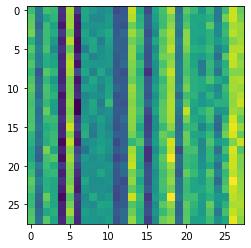

KeyboardInterrupt: 

In [11]:
for epoch in range(1, n_epochs + 1):

    #training + testing
    train(epoch)
    test(epoch)

    #saving model
    if epoch % save_every == 1:
        fn = 'saves/vrnn_state_dict_'+str(epoch)+'.pth'
        torch.save(model.state_dict(), fn)
        print('Saved model to '+fn)

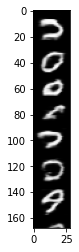

In [9]:
#hyperparameters
x_dim = 28
h_dim = 100
z_dim = 16
n_layers =  1

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


state_dict = torch.load('saves/vrnn_state_dict_41.pth')
model = VRNN(x_dim, h_dim, z_dim, n_layers)
model.load_state_dict(state_dict)
model.to(device)

sample = model.sample(28*6)
plt.imshow(sample.cpu().numpy(), cmap='gray')
plt.show()
